In [1]:
!pip install -q numpy pandas matplotlib statsmodels scipy itis-dakota tables h5py osparc_filecomms

In [2]:
import pathlib as pl
import uuid
import time
import math
impor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import dakota.environment as dakenv
import pandas
import h5py
from osparc_filecomms import handshakers

In [3]:
POLLING_INTERVAL=0.1
INPUT_SAMPLE_SIZE = 100
SAMPLE_SIZE = 20
SEED = 500
INPUT_MUS = [1.0, 50.0, 100.0]
INPUT_SIGMAS = [1.0, 5.0, 10.0]
NOISE_MUS = [0.0, 0.0]
NOISE_SIGMAS = [5.0, 10.0]
VAR_NAMES = ["X0", "X1", "X2"]
RESPONSE_NAMES = ["Y0", "Y1"]
MIN_X = -10
MAX_X = 150
DX=1
X_RANGE=range(MIN_X, MAX_X, DX)

In [4]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

output_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_OUTPUTS'])
output1_dir_path = output_dir_path / 'output_1'

input_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_INPUTS'])
input1_dir_path = input_dir_path / 'input_1'

dakota_conf_path = output1_dir_path / 'dakota.in'

In [5]:
def clean_output(dir_path):                                                                                                                                                                 
        for item in dir_path.iterdir():                                                                                                                                                               
            if item.is_dir():                                                                                                                                                                         
                shutil.rmtree(item)                                                                                                                                                                   
            else:                                                                                                                                                                                     
                item.unlink()      
clean_output(output1_dir_path)

In [6]:
def plot_hists(inputs, expected_params=None, suptitle=None):
    if expected_params is None:
        expected_params = [[0,1] for _ in range(len(inputs))]
    n_of_inputs = len(inputs)
    fig, axes = plt.subplots(1,n_of_inputs, figsize=(12,5))

    for input, ax, (expected_mu, expected_sigma) in zip(inputs, axes, expected_params):
        _, x, _ = ax.hist(input, bins=X_RANGE, density=True)
        ax.plot(x, scipy.stats.norm.pdf(x = x, loc = expected_mu, scale = expected_sigma), 'r', label='theoretical')
        ax.axvline(input.mean(), color='k', linestyle='dashed', linewidth=1)
        ax.set_xlim(MIN_X,MAX_X)
        ax.set_ylabel("density")
        ax.legend()

    
    fig.suptitle(suptitle) 
    plt.tight_layout()
    plt.show()

In [7]:
def plot_cdfs(datas, expected_params, suptitle=None):
    n_of_inputs = len(datas)
    fig, axes = plt.subplots(1,n_of_inputs, figsize=(12,5))

    for data, (expected_mu, expected_sigma), ax in zip(datas, expected_params, axes):
        counts, bins = np.histogram(data, bins=X_RANGE, density=True)
        x = bins[1:]
        pdf = counts/sum(counts)
        cdf = np.cumsum(pdf)
        ax.plot(x, scipy.stats.norm.cdf(x = x, loc = expected_mu, scale = expected_sigma), 'r', linewidth=2, label='theoretical')
        ax.plot(x, cdf, 'o', label='data')
        ax.set_xlim(MIN_X,MAX_X)
        ax.set_ylabel("fraction")
        ax.legend()
    
    fig.suptitle(suptitle) 
    plt.tight_layout()
    plt.show()

In [8]:
def plot_qq(datas, expected_params, suptitle=None):
    fig, axes = plt.subplots(1,len(datas), figsize=(12,5))

    for data, (expected_mu, expected_sigma), ax in zip(datas, expected_params, axes):
        sm.qqplot(data,  scipy.stats.norm, loc=expected_mu, scale=expected_sigma, ax=ax,line="45")

    fig.suptitle(suptitle) 
    plt.tight_layout()
    plt.show()

In [9]:
def generate_inputs(mus=INPUT_MUS, sigmas=INPUT_SIGMAS):
    np.random.seed(SEED)
    gaussians = []
    for mu, sigma in zip(mus, sigmas):
        gaussians.append(np.random.normal(mu, sigma, size=INPUT_SAMPLE_SIZE))

    return gaussians

inputs = generate_inputs()

In [86]:
def model_batch(inputs, mus=NOISE_MUS, sigmas=NOISE_SIGMAS):
    np.random.seed(SEED+1)
    outputs = [[] for _ in range(2)]
    gauss_noise0 = np.random.normal(mus[0], sigmas[0], size=SAMPLE_SIZE)
    gauss_noise1 = np.random.normal(mus[1], sigmas[1], size=SAMPLE_SIZE)
    outputs[0] = inputs[0] + inputs[1] + gauss_noise0
    outputs[1] = inputs[2] + gauss_noise1
    return outputs

def model(input, mus=NOISE_MUS, sigmas=NOISE_SIGMAS):
    x0, x1, x2 = input
    noise0 = np.random.normal(mus[0], sigmas[0])
    noise1 = np.random.normal(mus[1], sigmas[1])
    y0 = x0 + x1 + noise0
    y1 = x2 + noise1
    return y0, y1

In [87]:
outputs = model_batch([np.random.choice(input, SAMPLE_SIZE) for input in inputs])

In [88]:
expected_output_mus = np.zeros(2)
expected_output_sigmas = np.zeros(2)

expected_output_mus[0] = INPUT_MUS[0] + INPUT_MUS[1] + NOISE_MUS[0]
expected_output_mus[1] = INPUT_MUS[2] + NOISE_MUS[1]

expected_output_sigmas[0] = math.sqrt(math.pow(INPUT_SIGMAS[0],2.0) + math.pow(INPUT_SIGMAS[1],2.0) + math.pow(NOISE_SIGMAS[0],2.0))
expected_output_sigmas[1] = math.sqrt(math.pow(INPUT_SIGMAS[2],2.0) + math.pow(NOISE_SIGMAS[1],2.0))
print(expected_output_mus)
print(expected_output_sigmas)

[ 51. 100.]
[ 7.14142843 14.14213562]


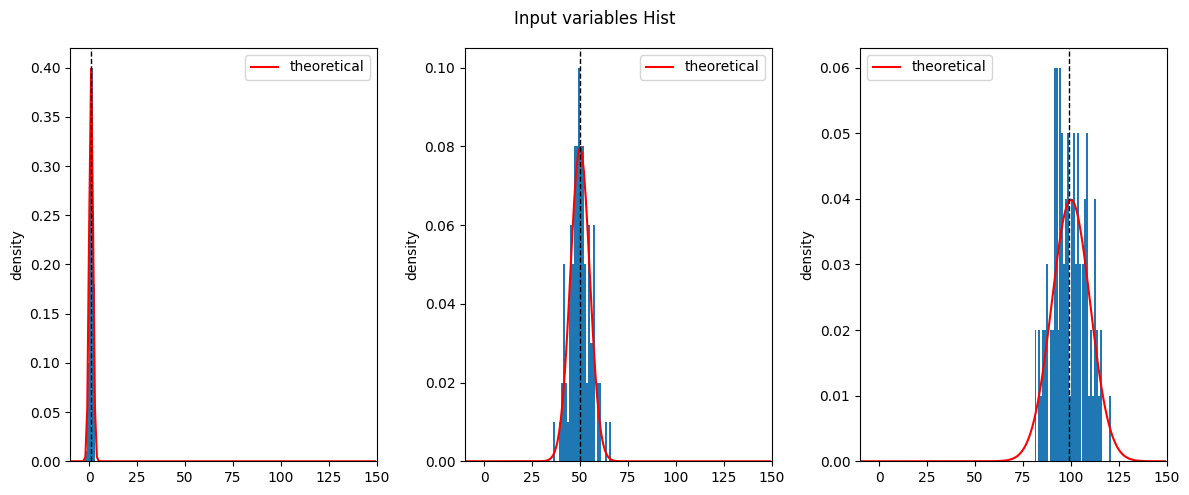

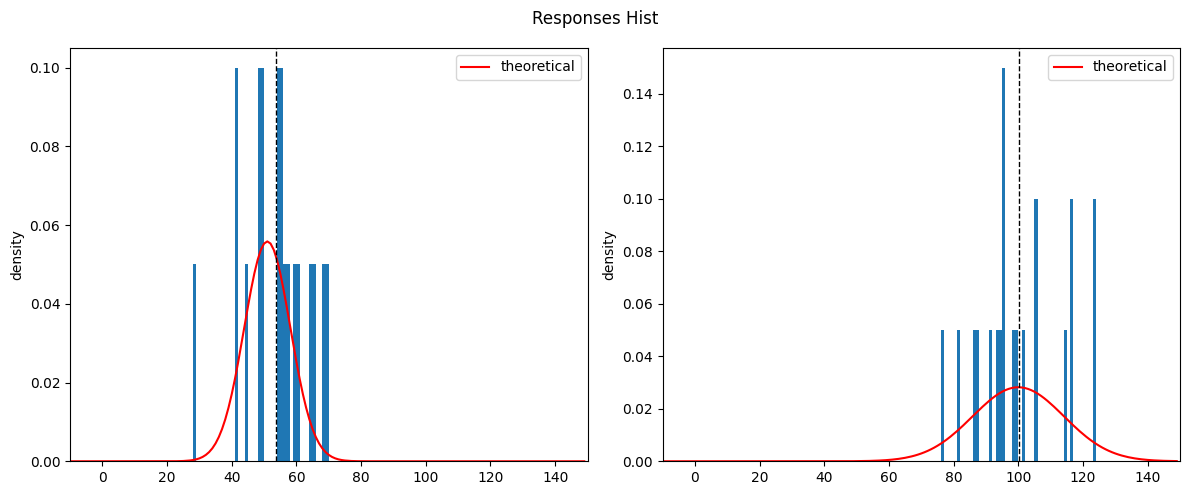

In [89]:
plot_hists(inputs, expected_params=zip(INPUT_MUS, INPUT_SIGMAS), suptitle='Input variables Hist')
plot_hists(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='Responses Hist')

In [14]:
inputs_counts_bins = [np.histogram(input, bins='auto') for input in inputs]
inputs_counts_bins = [(np.concatenate((counts,np.array([0]))), bins) for counts, bins in inputs_counts_bins]

In [15]:
def create_dakota_conf():
    response_levels = " ".join(str(number) for number in X_RANGE)
    response_descriptors = " ".join(f'"{response_name}"' for response_name in RESPONSE_NAMES)
    var_descriptors = " ".join(f'"{var_name}"' for var_name in VAR_NAMES)
    var_counts = "\t".join(" ".join([str(count) for count in counts]) for counts, _ in inputs_counts_bins)
    var_bins = "\t".join(" ".join([str(bin) for bin in bins]) for _, bins in inputs_counts_bins)
    var_pairs_per_var = "\t".join(str(len(counts)) for counts, _ in inputs_counts_bins)
    dakota_conf = f"""
environment
  tabular_data
    tabular_data_file = 'uq_sampling.dat'
  results_output
    hdf5
    results_output_file
      "dakota_results"
  top_method_pointer = 'UQ'
  

method
  id_method = 'UQ'
  sampling
    sample_type lhs
    samples = {SAMPLE_SIZE}
    seed = 12345
    output = silent
    response_levels = 
        {response_levels}
        {response_levels}
 
variables
  histogram_bin_uncertain = 3
    pairs_per_variable = {var_pairs_per_var}
    abscissas = {var_bins}
    counts = {var_counts}
    descriptors = {var_descriptors}
    
responses
  response_functions = 2
  descriptors = {response_descriptors}
  no_gradients
  no_hessians

interface
  id_interface = 'TRUTH_MODEL'
  analysis_drivers = 'model'
    batch
    python
"""
    return dakota_conf

In [16]:
dakota_conf = create_dakota_conf()
print(dakota_conf)


environment
  tabular_data
    tabular_data_file = 'uq_sampling.dat'
  results_output
    hdf5
    results_output_file
      "dakota_results"
  top_method_pointer = 'UQ'
  

method
  id_method = 'UQ'
  sampling
    sample_type lhs
    samples = 20
    seed = 12345
    output = silent
    response_levels = 
        -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
        -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 4

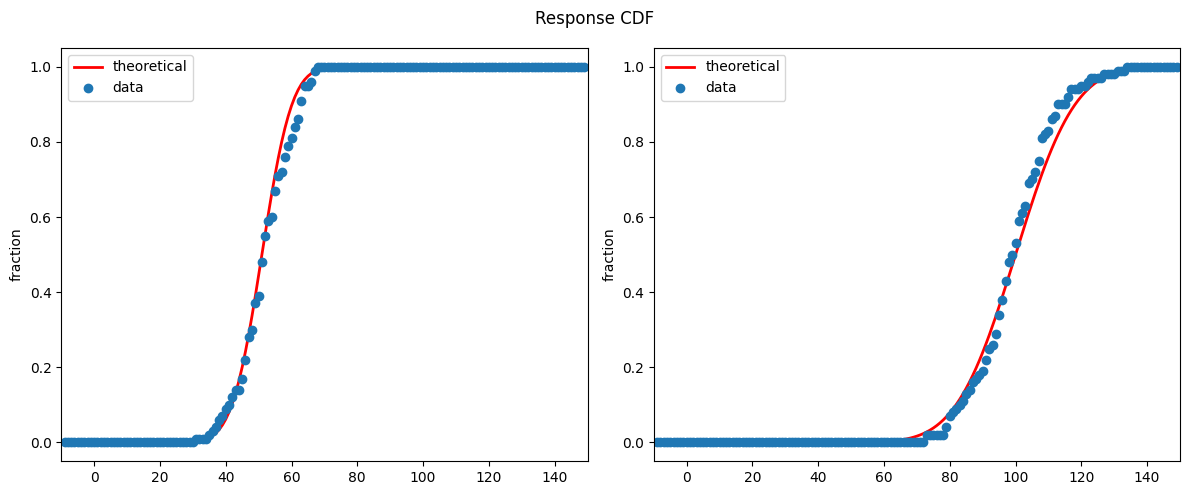

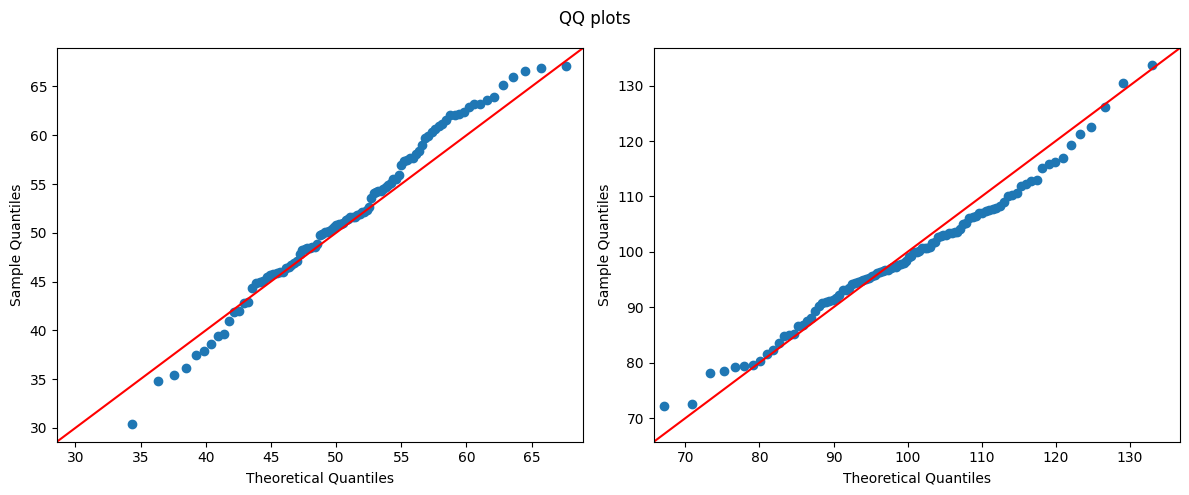

In [17]:
plot_cdfs(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='Response CDF')
plot_qq(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='QQ plots')

In [18]:

uuid = uuid.uuid4()
dakota_handshaker = handshakers.FileHandshaker(uuid, input1_dir_path, output1_dir_path)
dakota_handshaker.shake()

dakota_conf_path.write_text(dakota_conf)

2323

In [19]:
def read_results(results_path):
    def h5_open_wait(h5file):    
        wait = 3
    
        while True:
            try:
                h5f = h5py.File(h5file,'r')
                return h5f
                    
            except FileNotFoundError:
                return None
            
            except OSError:
                time.sleep(wait) 
        h5f.close()
        
    h5_open_wait(results_path)
    with h5py.File(results_path,'r') as results_file:
        cdfs = {}
        for response_name in RESPONSE_NAMES:
            results = results_file[f"/methods/UQ/results/execution:1/response_levels/{response_name}"]
            cdfs[response_name] = results[:results.len()]

    return cdfs

In [20]:
results_path = input1_dir_path / 'dakota_results.h5'
while not results_path.exists():
    time.sleep(POLLING_INTERVAL)
dakota_cdfs = read_results(results_path)

In [21]:
def plot_dakota_pdfs(cdfs, expected_params, suptitle=None):
    fig, axes = plt.subplots(1, len(cdfs),figsize=(12,5))

    for (response_name, cdf), ax, (expected_mu, expected_sigma) in zip(cdfs.items(), axes, expected_params):
        x = X_RANGE
        pdf = np.diff(cdf, prepend=0)
        ax.plot(x, scipy.stats.norm.pdf(x = x, loc = expected_mu, scale = expected_sigma), 'r', linewidth=2, label='theoretical')
        ax.bar(x, pdf, width=DX)
        ax.set_xlim(MIN_X,MAX_X)
        ax.set_xlabel(response_name)
        ax.set_ylabel("density")
        ax.legend()

    fig.suptitle(suptitle)
    fig.tight_layout()
    fig.show()

In [22]:
def plot_dakota_cdfs(cdfs, expected_params, suptitle=None):
    fig, axes = plt.subplots(1, len(cdfs),figsize=(12,5))

    for (response_name, cdf), ax, (expected_mu, expected_sigma) in zip(cdfs.items(), axes, expected_params):
        x = X_RANGE
        ax.plot(x, scipy.stats.norm.cdf(x = x, loc = expected_mu, scale = expected_sigma), 'r', linewidth=2, label='theoretical')
        ax.plot(x, cdf, 'o', label='data', alpha=0.4)
        ax.set_xlim(MIN_X,MAX_X)
        ax.set_xlabel(response_name)
        ax.set_ylabel("fraction")
        ax.legend()

    fig.suptitle(suptitle)
    fig.tight_layout()
    fig.show()

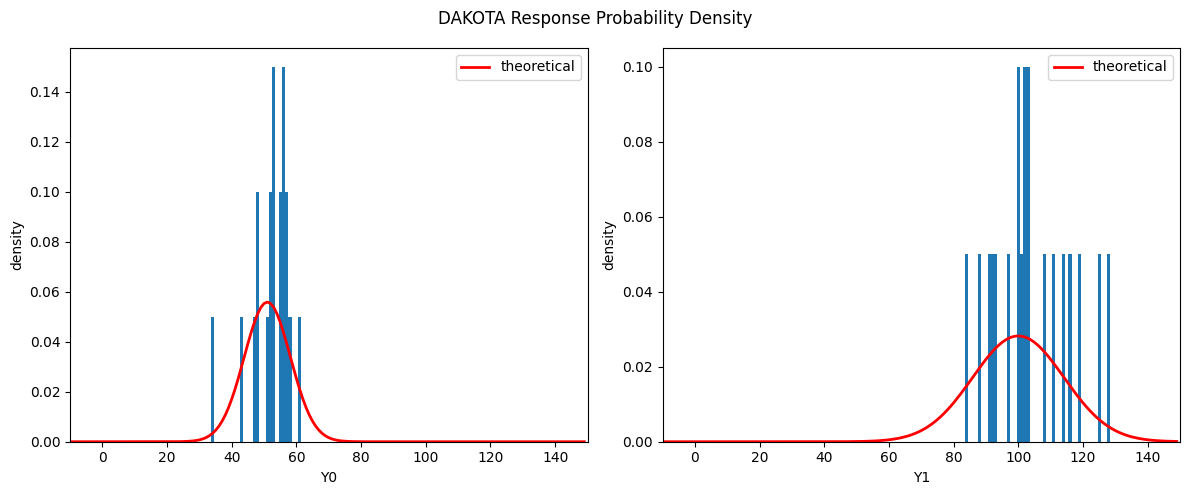

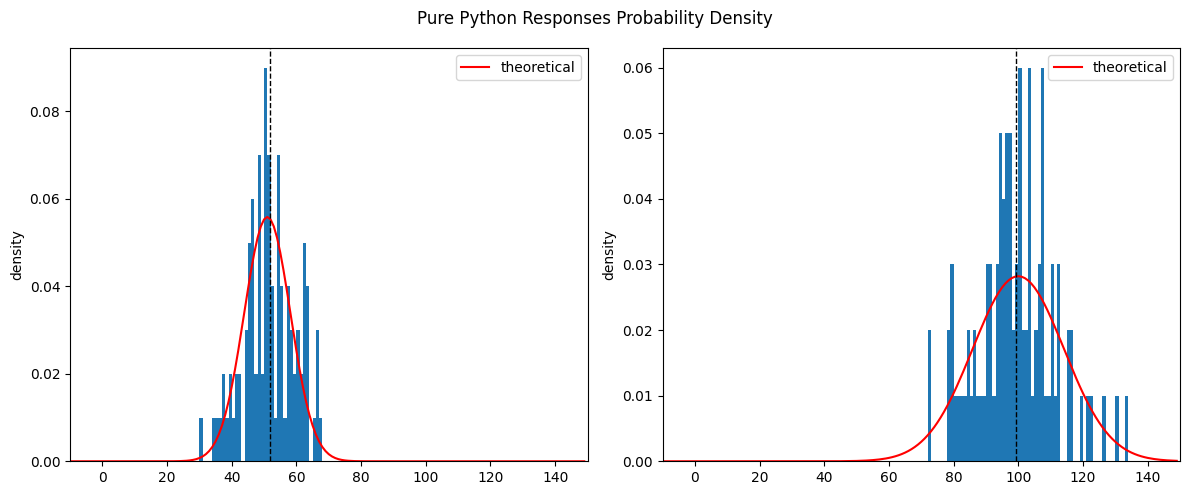

In [23]:
plot_dakota_pdfs(dakota_cdfs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='DAKOTA Response Probability Density')
plot_hists(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='Pure Python Responses Probability Density')

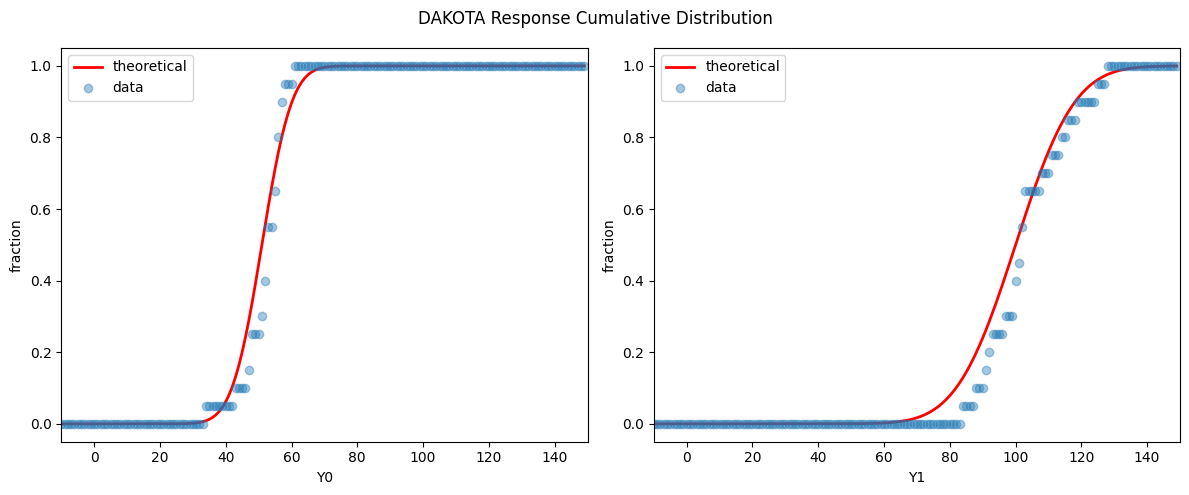

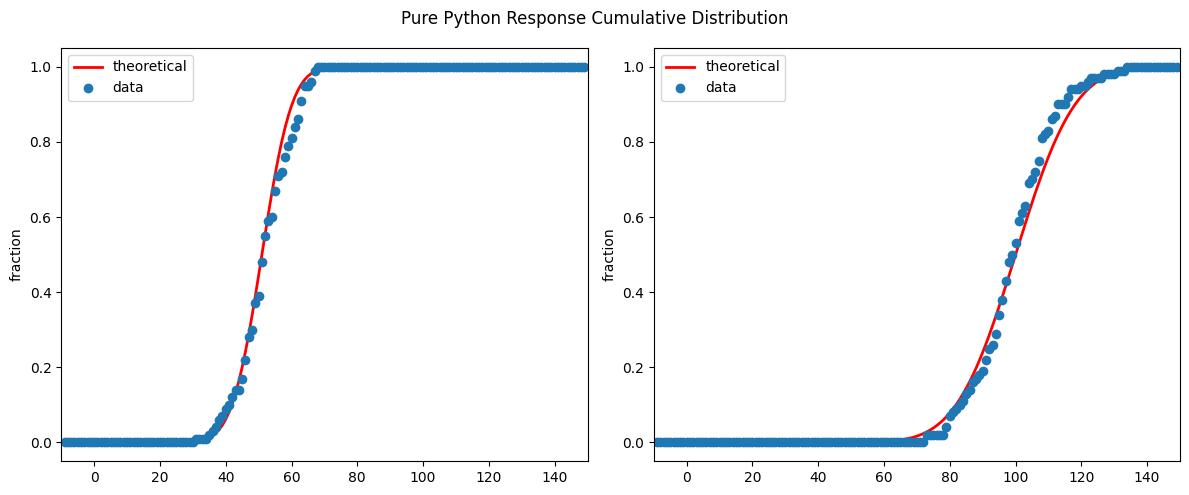

In [24]:
plot_dakota_cdfs(dakota_cdfs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='DAKOTA Response Cumulative Distribution')
plot_cdfs(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='Pure Python Response Cumulative Distribution')